In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV


In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [3]:
MSFT_m = pd.read_csv("./data/LOB_2012/MSFT_2012-06-21_34200000_57600000_message_10.csv", header=None)
MSFT_ob = pd.read_csv("./data/LOB_2012/MSFT_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
MSFT_m['ticker'] = 'MSFT'
MSFT_ob['ticker'] = 'MSFT'

AMZN_m = pd.read_csv("./data/LOB_2012/AMZN_2012-06-21_34200000_57600000_message_10.csv", header=None)
AMZN_ob = pd.read_csv("./data/LOB_2012/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
AMZN_m['ticker'] = 'AMZN'
AMZN_ob['ticker'] = 'AMZN'

AAPL_m = pd.read_csv("./data/LOB_2012/AAPL_2012-06-21_34200000_57600000_message_10.csv", header=None)
AAPL_ob = pd.read_csv("./data/LOB_2012/AAPL_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
AAPL_m['ticker'] = 'AAPL'
AAPL_ob['ticker'] = 'AAPL'

INTC_m = pd.read_csv("./data/LOB_2012/INTC_2012-06-21_34200000_57600000_message_10.csv", header=None)
INTC_ob = pd.read_csv("./data/LOB_2012/INTC_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
INTC_m['ticker'] = 'INTC'
INTC_ob['ticker'] = 'INTC'

GOOG_m = pd.read_csv("./data/LOB_2012/GOOG_2012-06-21_34200000_57600000_message_10.csv", header=None)
GOOG_ob = pd.read_csv("./data/LOB_2012/GOOG_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)
GOOG_m['ticker'] = 'GOOG'
GOOG_ob['ticker'] = 'GOOG'


df_m = pd.concat([MSFT_m, AMZN_m, AAPL_m, INTC_m, GOOG_m])
df_ob = pd.concat([MSFT_ob, AMZN_ob, AAPL_ob, INTC_ob, GOOG_ob])



In [4]:
M_header = ['time', 'event_type', 'order_ID',
            'size', 'price', 'direction', 'ticker']

df_m.columns = M_header


OB_header = []
for i in range(1, df_ob.shape[1]//4 + 1):
    OB_header.append(f'ask_price_{i}')
    OB_header.append(f'ask_size_{i}')
    OB_header.append(f'bid_price_{i}')
    OB_header.append(f'bid_size_{i}')

OB_header.append('ticker')

df_ob.columns = OB_header

In [5]:
df_m['time'] = pd.to_timedelta(df_m['time'], unit='s')

# Define the base date
base_date = pd.Timestamp('2012-06-21')

# Add the timedelta (time_sec) to the base date
df_m['datetime'] = base_date + df_m['time']

df_m.drop(columns=['time'], inplace=True)


In [6]:
# Creating event number
df_m['event_number'] = df_m.groupby('datetime').cumcount()
df_m['event_number_at_t'] = df_m.groupby('datetime')['event_type'].transform('count')

# Setting the composite index
df_m.set_index(['datetime', 'event_number', 'ticker'], inplace=True)

In [7]:
df_ob.index = df_m.index

In [8]:
df_ob['ask_price_1_prev'] = df_ob['ask_price_1'].shift()
df_ob['ask_size_1_prev'] = df_ob['ask_size_1'].shift()
df_ob['bid_price_1_prev'] = df_ob['bid_price_1'].shift()
df_ob['bid_size_1_prev'] = df_ob['bid_size_1'].shift()

In [9]:
# Define the start and end times
start_time = pd.to_datetime("09:15:00").time()
end_time = pd.to_datetime("15:45:00").time()

# Extract the 'datetime' level from the MultiIndex and filter based on the time
filtered_index = df_m.index.get_level_values('datetime').to_series().between_time(start_time, end_time).index

# Use the filtered index to get the filtered DataFrame
df_m_mh = df_m.loc[filtered_index]
df_ob_mh = df_ob.loc[filtered_index]

In [10]:
df_m_mh = df_m_mh[~df_m_mh.index.duplicated(keep='first')]
df_ob_mh = df_ob_mh[~df_ob_mh.index.duplicated(keep='first')]

Create features for ML prediction of direction

In [11]:
df_m_mh['midprice'] = (df_ob_mh['ask_price_1'] + df_ob_mh['bid_price_1']) / 2

In [12]:
df_m_mh['order_imb'] = (df_ob_mh['bid_size_1'] - df_ob_mh['ask_size_1']) / (df_ob_mh['bid_size_1'] + df_ob_mh['ask_size_1'])

We try to run ML models to predict the direction of hidden liquidity execution - these features mainly only make sense for event type 5

In [13]:
df_m_mh['prev_dir_t1'] = np.where(df_m_mh['event_type']==1, df_m_mh['direction'], np.nan)
df_m_mh['prev_dir_t1'] = df_m_mh['prev_dir_t1'].shift(1).ffill()
df_m_mh['prev_dir_t1'].fillna(0, inplace=True)

In [14]:
df_m_mh['next_dir_t1'] = np.where(df_m_mh['event_type']==1, df_m_mh['direction'], np.nan)
df_m_mh['next_dir_t1'] = df_m_mh['next_dir_t1'].shift(-1).bfill()
df_m_mh['next_dir_t1'].fillna(0, inplace=True)

In [15]:
df_m_mh['prev_dir_t4'] = np.where(df_m_mh['event_type']==4, df_m_mh['direction'], np.nan)
df_m_mh['prev_dir_t4'] = df_m_mh['prev_dir_t4'].shift(1).ffill()
df_m_mh['prev_dir_t4'].fillna(0, inplace=True)

In [16]:
df_m_mh['next_dir_t4'] = np.where(df_m_mh['event_type']==4, df_m_mh['direction'], np.nan)
df_m_mh['next_dir_t4'] = df_m_mh['next_dir_t4'].shift(-1).bfill()
df_m_mh['next_dir_t4'].fillna(0, inplace=True)

In [17]:
df_m_mh['next_dir_t3'] = np.where(df_m_mh['event_type']==3, df_m_mh['direction'], np.nan)
df_m_mh['next_dir_t3'] = df_m_mh['next_dir_t3'].shift(-1).bfill()
df_m_mh['next_dir_t3'].fillna(0, inplace=True)

In [18]:
df_m_mh['prev_dir_t3'] = np.where(df_m_mh['event_type']==3, df_m_mh['direction'], np.nan)
df_m_mh['prev_dir_t3'] = df_m_mh['prev_dir_t3'].shift(1).ffill()
df_m_mh['prev_dir_t3'].fillna(0, inplace=True)

In [19]:
df_m_mh[df_m_mh['event_type']==3]

,,,event_type,order_ID,size,price,direction,event_number_at_t,midprice,order_imb,prev_dir_t1,next_dir_t1,prev_dir_t4,next_dir_t4,next_dir_t3,prev_dir_t3
datetime,event_number,ticker,,,,,,,,,,,,,,
2012-06-21 09:30:00.013994120,0,MSFT,3,16085616,100,310400,-1,2,309700.0,-0.853229,0.0,-1.0,0.0,-1.0,-1.0,0.0
2012-06-21 09:30:00.016405181,0,MSFT,3,12703297,100,311300,-1,1,309700.0,-0.853229,-1.0,-1.0,0.0,-1.0,-1.0,-1.0
2012-06-21 09:30:00.016793836,0,MSFT,3,12665624,100,311400,-1,1,309700.0,-0.853229,-1.0,-1.0,0.0,-1.0,-1.0,-1.0
2012-06-21 09:30:00.017029005,0,MSFT,3,12665620,100,311500,-1,1,309700.0,-0.853229,-1.0,-1.0,0.0,-1.0,-1.0,-1.0
2012-06-21 09:30:00.017173303,0,MSFT,3,12665619,100,311600,-1,1,309700.0,-0.853229,-1.0,-1.0,0.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-06-21 15:44:58.702223676,0,GOOG,3,269395766,100,5653300,-1,1,5651500.0,0.333333,-1.0,-1.0,-1.0,0.0,-1.0,-1.0
2012-06-21 15:44:58.769782549,0,GOOG,3,269362917,100,5653500,-1,1,5651500.0,0.333333,-1.0,-1.0,-1.0,0.0,-1.0,-1.0
2012-06-21 15:44:58.769904413,0,GOOG,3,269414695,100,5653000,-1,1,5651700.0,0.980198,-1.0,-1.0,-1.0,0.0,1.0,-1.0


Get overall sentiment at the current time point. We look at past 5 trades.
- pos if buy interest
- neg if sell interest

In [20]:
conditions = [
    (df_m_mh['event_type'] == 1),
    (df_m_mh['event_type'] == 3),
    (df_m_mh['event_type'] == 4)
]

# Define corresponding values
values = [
    df_m_mh['direction'],
    -df_m_mh['direction'],
    df_m_mh['direction']
]

# Apply np.select
df_m_mh['sentiment'] = np.select(conditions, values, default=0)

In [21]:
df_m_mh['agg_sentiment_prev'] = df_m_mh['sentiment'].rolling(window=5).sum()
df_m_mh['agg_sentiment_prev'] = df_m_mh['agg_sentiment_prev'].fillna(0)

df_m_mh['agg_sentiment_aft'] = df_m_mh['sentiment'].iloc[::-1].rolling(window=5).sum().iloc[::-1]
df_m_mh['agg_sentiment_aft'] = df_m_mh['agg_sentiment_aft'].iloc[::-1].fillna(0)



In [22]:
df_m_mh['agg_ratio'] = (df_m_mh['price'] - df_ob_mh['bid_price_1']) / (df_ob_mh['ask_price_1'] - df_ob_mh['bid_price_1'])

In [23]:
df_m_mh['hid_at_best'] = (df_m_mh['price'] == df_ob_mh['bid_price_1']).astype(int) - (df_m_mh['price'] == df_ob_mh['ask_price_1']).astype(int)

We now specify the features we will use for prediction.

In [24]:
features_hid = df_m_mh[df_m_mh['event_type']==5]

We now drop features that are not relevant

In [25]:
features_hid.drop(columns=['event_type', 'order_ID', 'price', 'direction', 'midprice', 'sentiment'], inplace=True)

In [26]:
output_hid = df_m_mh[df_m_mh['event_type']==5]['direction']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features_hid, output_hid, test_size=0.25, random_state=42)

Random Forest Classifier

In [28]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [29]:
sum(y_pred == list(y_test))/len(y_pred)

np.float64(0.8596928982725528)

In [30]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Extract the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total tim

In [31]:
# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.87      0.87      0.87      2542
           1       0.88      0.87      0.87      2668

    accuracy                           0.87      5210
   macro avg       0.87      0.87      0.87      5210
weighted avg       0.87      0.87      0.87      5210



(array([2542.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2668.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

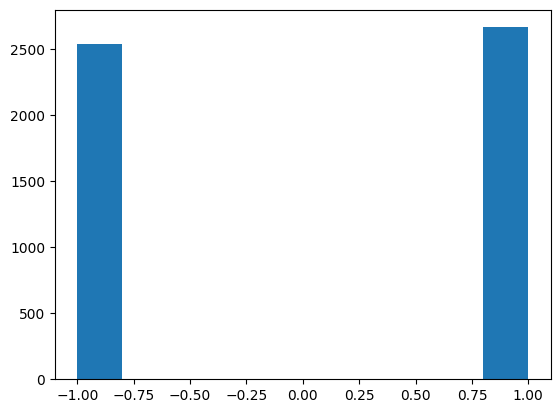

In [58]:
plt.hist(y_test)

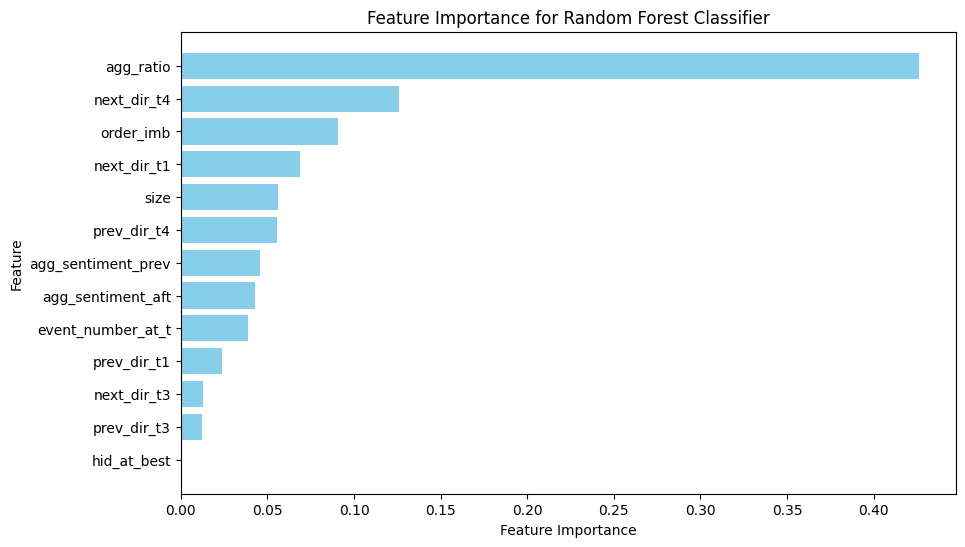

In [33]:
# Extract feature importances
feature_importances = best_model.feature_importances_

# Create a DataFrame for better visualization
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Classifier')
plt.gca().invert_yaxis()
plt.show()

Logistic Regression

In [34]:
X_train_lr = X_train.drop(columns=['size', 'event_number_at_t'])
X_test_lr = X_test.drop(columns=['size', 'event_number_at_t'])

Accuracy: 0.8349328214971209
Confusion Matrix:
 [[2123  419]
 [ 441 2227]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.83      0.84      0.83      2542
           1       0.84      0.83      0.84      2668

    accuracy                           0.83      5210
   macro avg       0.83      0.83      0.83      5210
weighted avg       0.83      0.83      0.83      5210

ROC AUC Score: 0.9179288699474024


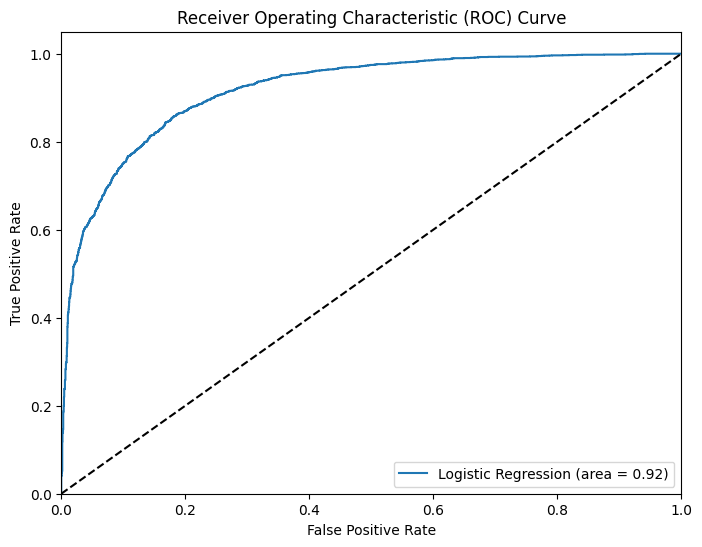

                    Coefficient
order_imb              0.099062
prev_dir_t1           -0.414922
next_dir_t1           -0.610849
prev_dir_t4            0.414634
next_dir_t4            0.465486
next_dir_t3            0.179151
prev_dir_t3            0.229341
agg_sentiment_prev     0.157954
agg_sentiment_aft     -0.011270
agg_ratio             -6.287936
hid_at_best           -3.404458


In [35]:
# Instantiate the Logistic Regression model
logreg = LogisticRegression(solver='liblinear')

# Fit the model to the training data
logreg.fit(X_train_lr, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test_lr)
y_pred_prob = logreg.predict_proba(X_test_lr)[:, 1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_pred_prob))
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print the model coefficients (feature importance)
coefficients = pd.DataFrame(logreg.coef_.flatten(), X_train_lr.columns, columns=['Coefficient'])
print(coefficients)

In [36]:
df_predicted_prob = pd.DataFrame(index=X_test_lr.index, data={'probabilities': y_pred_prob, 'predicted_dir':y_pred, 'true_dir':y_test})
df_predicted_prob

,,,probabilities,predicted_dir,true_dir
datetime,event_number,ticker,,,
2012-06-21 15:28:04.034923177,0,INTC,0.795923,1,1
2012-06-21 10:21:28.527662833,2,AAPL,0.991267,1,1
2012-06-21 14:47:44.394241923,0,INTC,0.137666,-1,-1
2012-06-21 14:03:02.297745768,0,INTC,0.384554,-1,-1
2012-06-21 15:38:38.345504779,0,INTC,0.213564,-1,-1
...,...,...,...,...,...
2012-06-21 09:52:04.992595849,0,AAPL,0.006758,-1,-1
2012-06-21 09:51:30.374351444,1,AAPL,0.946448,1,1
2012-06-21 13:52:42.651090805,1,AAPL,0.914574,1,1


In [46]:
df_predicted_prob['diff_from_rand'] = (df_predicted_prob['probabilities'] - 0.5).abs()
df_predicted_prob.sort_values(by='diff_from_rand')

,,,probabilities,predicted_dir,true_dir,diff_from_rand
datetime,event_number,ticker,,,,
2012-06-21 11:48:39.261491017,1,AAPL,0.500087,1,1,0.000087
2012-06-21 10:53:38.180453059,0,MSFT,0.499479,-1,1,0.000521
2012-06-21 12:23:36.912921609,0,AAPL,0.500802,1,1,0.000802
2012-06-21 13:41:39.254866627,0,AAPL,0.501005,1,-1,0.001005
2012-06-21 15:32:59.214826862,0,INTC,0.501474,1,1,0.001474
...,...,...,...,...,...,...
2012-06-21 12:43:54.259217264,1,GOOG,0.996563,1,1,0.496563
2012-06-21 11:09:05.863813552,2,GOOG,0.996731,1,1,0.496731
2012-06-21 14:24:15.249327321,1,GOOG,0.003079,-1,-1,0.496921


In [41]:
specific_timestamp = pd.Timestamp('2012-06-21 11:48:39.261491017')
df_m_mh.index.get_loc((specific_timestamp, 1, 'AAPL'))
# SPY_m[SPY_m.index.get_level_values('datetime') == specific_timestamp]

1017786

Infer direction of hidden liquidity execution when there is an event type 4 happening at the same time frame (tag as same direction)

In [47]:
mult_event_hid_idx = df_m_mh.index.get_level_values('datetime').isin(df_m_mh[df_m_mh['event_number_at_t'] != 1].index.get_level_values('datetime'))

In [48]:
idx_mult_event_buy_vis = df_m_mh[mult_event_hid_idx][(df_m_mh[mult_event_hid_idx]['event_type'] == 4) & (df_m_mh[mult_event_hid_idx]['direction'] == 1)].index
idx_mult_event_sell_vis = df_m_mh[mult_event_hid_idx][(df_m_mh[mult_event_hid_idx]['event_type'] == 4) & (df_m_mh[mult_event_hid_idx]['direction'] == -1)].index

In [49]:
dt_mult_event_buy_vis = idx_mult_event_buy_vis.get_level_values('datetime').unique()
dt_mult_event_sell_vis = idx_mult_event_sell_vis.get_level_values('datetime').unique()

In [50]:
df_predicted_prob.loc[df_predicted_prob.index.get_level_values('datetime').isin(dt_mult_event_buy_vis), 'predicted_dir'] = 1
df_predicted_prob.loc[df_predicted_prob.index.get_level_values('datetime').isin(dt_mult_event_sell_vis), 'predicted_dir'] = -1

In [52]:
sum(df_predicted_prob['predicted_dir'] == df_predicted_prob['true_dir'])/len(df_predicted_prob)

0.8558541266794626

Infer direction of hidden liquidity execution when there is an event type 1 happening at the same time frame (tag as opposite direction)

In [53]:
idx_mult_sub_buy = df_m_mh[mult_event_hid_idx][(df_m_mh[mult_event_hid_idx]['event_type'] == 1) & (df_m_mh[mult_event_hid_idx]['direction'] == 1)].index
idx_mult_sub_sell = df_m_mh[mult_event_hid_idx][(df_m_mh[mult_event_hid_idx]['event_type'] == 1) & (df_m_mh[mult_event_hid_idx]['direction'] == -1)].index

In [55]:
dt_mult_sub_buy = idx_mult_sub_buy.get_level_values('datetime').unique()
dt_mult_sub_sell = idx_mult_sub_sell.get_level_values('datetime').unique()

In [56]:
df_predicted_prob.loc[df_predicted_prob.index.get_level_values('datetime').isin(dt_mult_sub_buy), 'predicted_dir'] = -1
df_predicted_prob.loc[df_predicted_prob.index.get_level_values('datetime').isin(dt_mult_sub_sell), 'predicted_dir'] = 1

In [59]:
sum(df_predicted_prob['predicted_dir'] == df_predicted_prob['true_dir'])/len(df_predicted_prob)

0.8575815738963531

Exploratory Data - for OFI

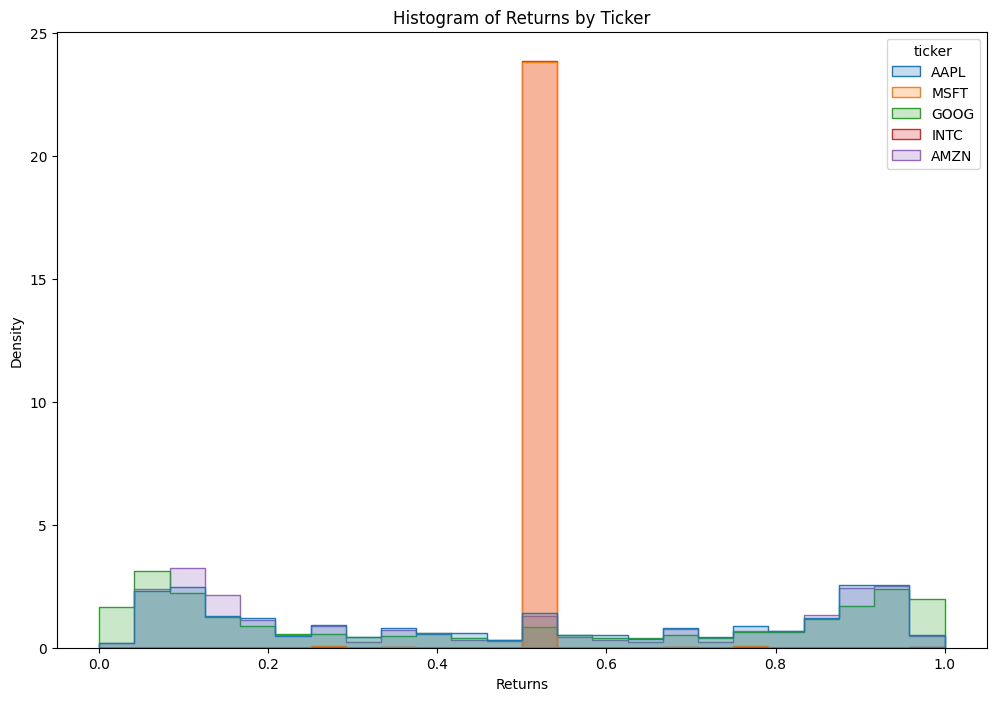

In [65]:
plt.figure(figsize=(12, 8))
sns.histplot(data=X_train, x='agg_ratio', hue='ticker', element='step', stat='density', common_norm=False)

plt.xlabel('Returns')
plt.ylabel('Density')
plt.title('Histogram of Returns by Ticker')
plt.show()